# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

keywords are unexpanded, not using


In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  1.452186 -1.148627  0.0  0.710725  0.078256  2.341689  2  0  25.880241   
1 -1.605302 -0.333977  1.0  0.716749 -1.469557  0.668318  1  3  25.560936   
2 -1.637438 -1.586729  0.0  0.528480  0.141544  0.907604  0  0  12.307176   
3 -2.171132 -0.760242  1.0  0.580722  1.298183  1.470600  3  0  40.714400   
4 -2.648073  0.062232  1.0  0.454143  0.865844 -0.152630  1  2  29.145859   

            y  
0  215.389676  
1  195.810983  
2   45.173522  
3  241.833863  
4  233.179707  
True causal estimate is 7.952448006579925


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

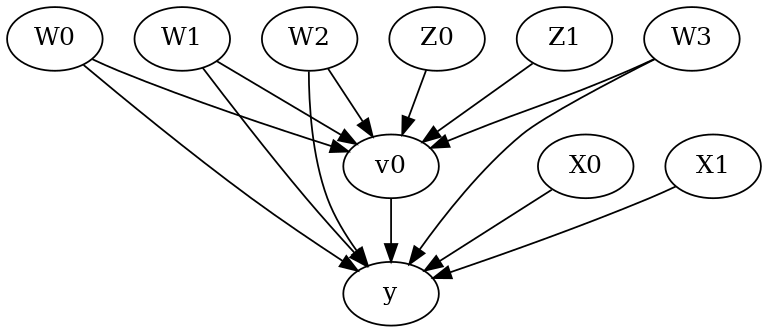

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W0,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,U) = P(y|v0,W1,W2,W0,W3)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['X0', 'X1']}


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W0,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,U) = P(y|v0,W1,W2,W0,W3)

## Realized estimand
b: y~v0+W1+W2+W0+W3+v0*X0+v0*X1
Target units: ate

## Estimate
Mean value: 7.952443716239365
### Conditional Estimates
__categorical__X0  __categorical__X1
(-4.283, -1.344]   (-4.024, -1.318]      2.279986
                   (-1.318, -0.739]      4.924629
                   (-0.739, -0.226]      6.603290
                   (-0.226, 0.358]       8.338141
                   (0.358, 3.201]       11.188621
(-1.344, -0.752]   (-4.024, -1.318]      2.874091
                   (-1.318, -0.739]      5.720353
                   (-0.739, -0.226]      7.411814
                   (-0.226, 0.358]       9.124025
                   (0.358, 3.201]       11.81213

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W0,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,U) = P(y|v0,W1,W2,W0,W3)

## Realized estimand
b: y~v0+W1+W2+W0+W3 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 9.899183560354105
Effect estimates: [ 7.61397313  8.87535587  5.71532194 17.06858628  4.37146961 11.75664338
  8.38993748  4.65249255 11.55333951  4.2635059   2.59323014 13.9786986
 16.63039972  7.3516366   9.76217454  6.51218229  6.14815109  6.94916936
  9.19672536 10.91728714 14.11444442  9.43383458 13.92369179  7.39095425
  9.57312071  8.42306612  7.91328717  0.80113567  8.6913544   8.09160627
  9.88443438 11.93828145 15.07199562  7.45475102 10.00795304  7.7340278
 11.69473312  8.22472252  5.20664157  6.71146882 19.53507587  4.67784526
  7.2703

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 7.952448006579925


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W0,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,U) = P(y|v0,W1,W2,W0,W3)

## Realized estimand
b: y~v0+W1+W2+W0+W3 | X0,X1
Target units: 

## Estimate
Mean value: 7.932560580719904
Effect estimates: [ 7.54315018  7.39663488  3.27095398 ...  6.80015991 10.54326542
 11.43528933]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W0,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,U) = P(y|v0,W1,W2,W0,W3)

## Realized estimand
b: y~v0+W1+W2+W0+W3 | X0,X1
Target units: ate

## Estimate
Mean value: 7.895862960402595
Effect estimates: [ 7.58589048  7.32365548  3.2435527  ...  6.75716625 10.50125986
 11.27100652]
95.0% confidence interval: (array([ 7.53880452,  7.30155495,  3.11363372, ...,  6.75688622,
       10.5502796 , 11.18450523]), array([ 7.8069654 ,  7.48818378,  3.35286968, ...,  6.88965535,
       10.74413471, 11.60650639]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[11.46466704 10.70500839 12.73216454 12.42823999 11.73387788 12.65686175
 11.22210112 13.17763977 10.56043766 12.02460663]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0     0.802263  1.811942  0.0  0.787768  0.503974 -0.049193  0.870776   
1     0.837899  1.489831  0.0  0.001845  0.486054 -1.380343  0.855092   
2     0.855275  1.368969  1.0  0.566011  1.825993 -0.520806  0.760183   
3     2.224660 -2.176080  0.0  0.122451  0.417770 -0.927046  1.313059   
4     0.599264 -1.244798  0.0  0.090315 -0.579284 -1.085069  0.320814   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -1.052016  0.363309  0.0  0.487990  0.268449 -1.175763  1.440053   
9996  1.083443  0.423901  0.0  0.081171  0.332246  1.645099 -0.167441   
9997  1.256516  0.933759  0.0  0.867597  1.881055  1.562773  3.340539   
9998 -0.045578 -0.422095  0.0  0.253861  0.510396  2.850437  0.545809   
9999 -0.003787  2.221526  1.0  0.778764 -0.602576 -0.162174 -0.833540   

            W3  v0  y  
0    -0.722403   1  1  
1    -1.455232   0  0  
2    -0.284049   1  1  
3    -1.196832   0  0  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W0,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,U) = P(y|v0,W1,W2,W0,W3)

## Realized estimand
b: y~v0+W1+W2+W0+W3 | X0,X1
Target units: ate

## Estimate
Mean value: 0.628733350065336
Effect estimates: [0.72887727 0.71329373 0.70764866 ... 0.70442317 0.56550308 0.71027868]

True causal estimate is 0.3687


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-07-15 14:32:32.576294: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /__t/Python/3.10.5/x64/lib
2022-07-15 14:32:32.576338: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-07-15 14:32:34.343752: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /__t/Python/3.10.5/x64/lib
2022-07-15 14:32:34.343797: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-15 14:32:34.343825: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f261e7f0b1dc): /proc/driver/nvidia/version does not exist
2022-07-15 14:32:34.344126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 3:36 - loss: 197.3885

 30/313 [=>............................] - ETA: 0s - loss: 66.5539   

 59/313 [====>.........................] - ETA: 0s - loss: 36.9714

 89/313 [=======>......................] - ETA: 0s - loss: 26.1894

119/313 [==========>...................] - ETA: 0s - loss: 20.7824

148/313 [=============>................] - ETA: 0s - loss: 17.6154

178/313 [================>.............] - ETA: 0s - loss: 15.3947

207/313 [==================>...........] - ETA: 0s - loss: 13.8603

236/313 [=====================>........] - ETA: 0s - loss: 12.6997

264/313 [========================>.....] - ETA: 0s - loss: 11.8098

294/313 [===========================>..] - ETA: 0s - loss: 11.0447

313/313 [==============================] - 1s 2ms/step - loss: 10.6326


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 4.2467

 31/313 [=>............................] - ETA: 0s - loss: 4.1856

 61/313 [====>.........................] - ETA: 0s - loss: 4.2008

 91/313 [=======>......................] - ETA: 0s - loss: 4.1852

121/313 [==========>...................] - ETA: 0s - loss: 4.1537

151/313 [=============>................] - ETA: 0s - loss: 4.1391

181/313 [================>.............] - ETA: 0s - loss: 4.1113

211/313 [===================>..........] - ETA: 0s - loss: 4.0890

242/313 [======================>.......] - ETA: 0s - loss: 4.0531

273/313 [=========================>....] - ETA: 0s - loss: 4.0041

302/313 [===========================>..] - ETA: 0s - loss: 3.9565

313/313 [==============================] - 1s 2ms/step - loss: 3.9382


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 3.5818

 32/313 [==>...........................] - ETA: 0s - loss: 3.2912

 61/313 [====>.........................] - ETA: 0s - loss: 3.2896

 90/313 [=======>......................] - ETA: 0s - loss: 3.2826

119/313 [==========>...................] - ETA: 0s - loss: 3.2412

145/313 [============>.................] - ETA: 0s - loss: 3.2362

172/313 [===============>..............] - ETA: 0s - loss: 3.2223

200/313 [==================>...........] - ETA: 0s - loss: 3.2103

230/313 [=====================>........] - ETA: 0s - loss: 3.1971

259/313 [=======================>......] - ETA: 0s - loss: 3.1945

289/313 [==========================>...] - ETA: 0s - loss: 3.1848

313/313 [==============================] - 1s 2ms/step - loss: 3.1753


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 2.7209

 31/313 [=>............................] - ETA: 0s - loss: 3.0696

 62/313 [====>.........................] - ETA: 0s - loss: 3.0370

 92/313 [=======>......................] - ETA: 0s - loss: 3.0467

122/313 [==========>...................] - ETA: 0s - loss: 3.0339

152/313 [=============>................] - ETA: 0s - loss: 3.0253

183/313 [================>.............] - ETA: 0s - loss: 3.0094

214/313 [===================>..........] - ETA: 0s - loss: 3.0029

244/313 [======================>.......] - ETA: 0s - loss: 2.9965

274/313 [=========================>....] - ETA: 0s - loss: 2.9952

303/313 [============================>.] - ETA: 0s - loss: 2.9936

313/313 [==============================] - 1s 2ms/step - loss: 2.9947


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 2.7500

 31/313 [=>............................] - ETA: 0s - loss: 2.9472

 61/313 [====>.........................] - ETA: 0s - loss: 2.9473

 91/313 [=======>......................] - ETA: 0s - loss: 2.9727

121/313 [==========>...................] - ETA: 0s - loss: 2.9638

151/313 [=============>................] - ETA: 0s - loss: 2.9548

182/313 [================>.............] - ETA: 0s - loss: 2.9509

211/313 [===================>..........] - ETA: 0s - loss: 2.9491

240/313 [======================>.......] - ETA: 0s - loss: 2.9476

269/313 [========================>.....] - ETA: 0s - loss: 2.9444

288/313 [==========================>...] - ETA: 0s - loss: 2.9425

313/313 [==============================] - ETA: 0s - loss: 2.9398

313/313 [==============================] - 1s 2ms/step - loss: 2.9398


Epoch 6/25


  1/313 [..............................] - ETA: 0s - loss: 2.9921

 31/313 [=>............................] - ETA: 0s - loss: 2.8740

 60/313 [====>.........................] - ETA: 0s - loss: 2.8829

 90/313 [=======>......................] - ETA: 0s - loss: 2.8799

119/313 [==========>...................] - ETA: 0s - loss: 2.8791

149/313 [=============>................] - ETA: 0s - loss: 2.8845

179/313 [================>.............] - ETA: 0s - loss: 2.8852

209/313 [===================>..........] - ETA: 0s - loss: 2.8904

238/313 [=====================>........] - ETA: 0s - loss: 2.8822

266/313 [========================>.....] - ETA: 0s - loss: 2.8866

295/313 [===========================>..] - ETA: 0s - loss: 2.8806

313/313 [==============================] - 1s 2ms/step - loss: 2.8741


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 2.8639

 31/313 [=>............................] - ETA: 0s - loss: 2.8291

 60/313 [====>.........................] - ETA: 0s - loss: 2.8321

 88/313 [=======>......................] - ETA: 0s - loss: 2.8310

117/313 [==========>...................] - ETA: 0s - loss: 2.8172

147/313 [=============>................] - ETA: 0s - loss: 2.8133

176/313 [===============>..............] - ETA: 0s - loss: 2.8128

205/313 [==================>...........] - ETA: 0s - loss: 2.8051

235/313 [=====================>........] - ETA: 0s - loss: 2.8034

265/313 [========================>.....] - ETA: 0s - loss: 2.8043

295/313 [===========================>..] - ETA: 0s - loss: 2.8025

313/313 [==============================] - 1s 2ms/step - loss: 2.8014


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 2.6707

 31/313 [=>............................] - ETA: 0s - loss: 2.7771

 61/313 [====>.........................] - ETA: 0s - loss: 2.7556

 90/313 [=======>......................] - ETA: 0s - loss: 2.7815

120/313 [==========>...................] - ETA: 0s - loss: 2.7842

148/313 [=============>................] - ETA: 0s - loss: 2.7878

178/313 [================>.............] - ETA: 0s - loss: 2.7827

206/313 [==================>...........] - ETA: 0s - loss: 2.7793

233/313 [=====================>........] - ETA: 0s - loss: 2.7757

262/313 [========================>.....] - ETA: 0s - loss: 2.7687

292/313 [==========================>...] - ETA: 0s - loss: 2.7661

313/313 [==============================] - 1s 2ms/step - loss: 2.7598


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 2.9172

 32/313 [==>...........................] - ETA: 0s - loss: 2.7691

 62/313 [====>.........................] - ETA: 0s - loss: 2.7798

 92/313 [=======>......................] - ETA: 0s - loss: 2.7636

122/313 [==========>...................] - ETA: 0s - loss: 2.7526

153/313 [=============>................] - ETA: 0s - loss: 2.7474

184/313 [================>.............] - ETA: 0s - loss: 2.7472

214/313 [===================>..........] - ETA: 0s - loss: 2.7446

244/313 [======================>.......] - ETA: 0s - loss: 2.7433

274/313 [=========================>....] - ETA: 0s - loss: 2.7401

305/313 [============================>.] - ETA: 0s - loss: 2.7383

313/313 [==============================] - 1s 2ms/step - loss: 2.7375


Epoch 10/25


  1/313 [..............................] - ETA: 0s - loss: 2.7786

 30/313 [=>............................] - ETA: 0s - loss: 2.7046

 58/313 [====>.........................] - ETA: 0s - loss: 2.7249

 86/313 [=======>......................] - ETA: 0s - loss: 2.7104

115/313 [==========>...................] - ETA: 0s - loss: 2.7156

144/313 [============>.................] - ETA: 0s - loss: 2.7174

173/313 [===============>..............] - ETA: 0s - loss: 2.7186

201/313 [==================>...........] - ETA: 0s - loss: 2.7218

230/313 [=====================>........] - ETA: 0s - loss: 2.7198

258/313 [=======================>......] - ETA: 0s - loss: 2.7195

288/313 [==========================>...] - ETA: 0s - loss: 2.7212

313/313 [==============================] - 1s 2ms/step - loss: 2.7230


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 2.7154

 31/313 [=>............................] - ETA: 0s - loss: 2.6875

 61/313 [====>.........................] - ETA: 0s - loss: 2.6939

 91/313 [=======>......................] - ETA: 0s - loss: 2.6943

121/313 [==========>...................] - ETA: 0s - loss: 2.7034

151/313 [=============>................] - ETA: 0s - loss: 2.7001

179/313 [================>.............] - ETA: 0s - loss: 2.7052

209/313 [===================>..........] - ETA: 0s - loss: 2.7091

239/313 [=====================>........] - ETA: 0s - loss: 2.7090

269/313 [========================>.....] - ETA: 0s - loss: 2.7123

299/313 [===========================>..] - ETA: 0s - loss: 2.7165

313/313 [==============================] - 1s 2ms/step - loss: 2.7147


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 2.7128

 32/313 [==>...........................] - ETA: 0s - loss: 2.6930

 62/313 [====>.........................] - ETA: 0s - loss: 2.6788

 93/313 [=======>......................] - ETA: 0s - loss: 2.6891

124/313 [==========>...................] - ETA: 0s - loss: 2.6913

155/313 [=============>................] - ETA: 0s - loss: 2.6951

186/313 [================>.............] - ETA: 0s - loss: 2.7002

215/313 [===================>..........] - ETA: 0s - loss: 2.6980

244/313 [======================>.......] - ETA: 0s - loss: 2.7032

274/313 [=========================>....] - ETA: 0s - loss: 2.7018

305/313 [============================>.] - ETA: 0s - loss: 2.6991

313/313 [==============================] - 1s 2ms/step - loss: 2.7005


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 2.8103

 32/313 [==>...........................] - ETA: 0s - loss: 2.7458

 61/313 [====>.........................] - ETA: 0s - loss: 2.7200

 90/313 [=======>......................] - ETA: 0s - loss: 2.7208

119/313 [==========>...................] - ETA: 0s - loss: 2.7132

149/313 [=============>................] - ETA: 0s - loss: 2.7149

180/313 [================>.............] - ETA: 0s - loss: 2.7080

210/313 [===================>..........] - ETA: 0s - loss: 2.6999

240/313 [======================>.......] - ETA: 0s - loss: 2.6940

270/313 [========================>.....] - ETA: 0s - loss: 2.6934

301/313 [===========================>..] - ETA: 0s - loss: 2.6956

313/313 [==============================] - 1s 2ms/step - loss: 2.6961


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 2.9451

 33/313 [==>...........................] - ETA: 0s - loss: 2.7261

 63/313 [=====>........................] - ETA: 0s - loss: 2.7170

 91/313 [=======>......................] - ETA: 0s - loss: 2.7009

119/313 [==========>...................] - ETA: 0s - loss: 2.6970

148/313 [=============>................] - ETA: 0s - loss: 2.6887

177/313 [===============>..............] - ETA: 0s - loss: 2.6890

208/313 [==================>...........] - ETA: 0s - loss: 2.6956

239/313 [=====================>........] - ETA: 0s - loss: 2.6942

270/313 [========================>.....] - ETA: 0s - loss: 2.6926

300/313 [===========================>..] - ETA: 0s - loss: 2.6916

313/313 [==============================] - 1s 2ms/step - loss: 2.6907


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 2.9929

 32/313 [==>...........................] - ETA: 0s - loss: 2.6676

 63/313 [=====>........................] - ETA: 0s - loss: 2.6793

 91/313 [=======>......................] - ETA: 0s - loss: 2.6863

119/313 [==========>...................] - ETA: 0s - loss: 2.6833

147/313 [=============>................] - ETA: 0s - loss: 2.6907

176/313 [===============>..............] - ETA: 0s - loss: 2.6874

206/313 [==================>...........] - ETA: 0s - loss: 2.6875

236/313 [=====================>........] - ETA: 0s - loss: 2.6815

266/313 [========================>.....] - ETA: 0s - loss: 2.6804

296/313 [===========================>..] - ETA: 0s - loss: 2.6778

313/313 [==============================] - 1s 2ms/step - loss: 2.6784


Epoch 16/25


  1/313 [..............................] - ETA: 0s - loss: 2.6070

 31/313 [=>............................] - ETA: 0s - loss: 2.6645

 62/313 [====>.........................] - ETA: 0s - loss: 2.6733

 93/313 [=======>......................] - ETA: 0s - loss: 2.6755

123/313 [==========>...................] - ETA: 0s - loss: 2.6767

153/313 [=============>................] - ETA: 0s - loss: 2.6724

183/313 [================>.............] - ETA: 0s - loss: 2.6720

213/313 [===================>..........] - ETA: 0s - loss: 2.6757

241/313 [======================>.......] - ETA: 0s - loss: 2.6801

271/313 [========================>.....] - ETA: 0s - loss: 2.6768

300/313 [===========================>..] - ETA: 0s - loss: 2.6799

313/313 [==============================] - 1s 2ms/step - loss: 2.6802


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 2.6377

 31/313 [=>............................] - ETA: 0s - loss: 2.6290

 60/313 [====>.........................] - ETA: 0s - loss: 2.6632

 89/313 [=======>......................] - ETA: 0s - loss: 2.6673

118/313 [==========>...................] - ETA: 0s - loss: 2.6688

146/313 [============>.................] - ETA: 0s - loss: 2.6700

174/313 [===============>..............] - ETA: 0s - loss: 2.6743

202/313 [==================>...........] - ETA: 0s - loss: 2.6708

230/313 [=====================>........] - ETA: 0s - loss: 2.6738

259/313 [=======================>......] - ETA: 0s - loss: 2.6709

288/313 [==========================>...] - ETA: 0s - loss: 2.6709

313/313 [==============================] - 1s 2ms/step - loss: 2.6689


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 2.5970

 30/313 [=>............................] - ETA: 0s - loss: 2.6867

 61/313 [====>.........................] - ETA: 0s - loss: 2.6925

 91/313 [=======>......................] - ETA: 0s - loss: 2.6737

121/313 [==========>...................] - ETA: 0s - loss: 2.6666

151/313 [=============>................] - ETA: 0s - loss: 2.6562

181/313 [================>.............] - ETA: 0s - loss: 2.6603

212/313 [===================>..........] - ETA: 0s - loss: 2.6637

244/313 [======================>.......] - ETA: 0s - loss: 2.6625

274/313 [=========================>....] - ETA: 0s - loss: 2.6621

304/313 [============================>.] - ETA: 0s - loss: 2.6631

313/313 [==============================] - 1s 2ms/step - loss: 2.6628


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 2.6218

 31/313 [=>............................] - ETA: 0s - loss: 2.6521

 61/313 [====>.........................] - ETA: 0s - loss: 2.6665

 92/313 [=======>......................] - ETA: 0s - loss: 2.6632

122/313 [==========>...................] - ETA: 0s - loss: 2.6762

151/313 [=============>................] - ETA: 0s - loss: 2.6766

179/313 [================>.............] - ETA: 0s - loss: 2.6733

207/313 [==================>...........] - ETA: 0s - loss: 2.6738

236/313 [=====================>........] - ETA: 0s - loss: 2.6707

265/313 [========================>.....] - ETA: 0s - loss: 2.6694

294/313 [===========================>..] - ETA: 0s - loss: 2.6687

313/313 [==============================] - 1s 2ms/step - loss: 2.6713


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 2.6399

 31/313 [=>............................] - ETA: 0s - loss: 2.6629

 62/313 [====>.........................] - ETA: 0s - loss: 2.6694

 93/313 [=======>......................] - ETA: 0s - loss: 2.6679

124/313 [==========>...................] - ETA: 0s - loss: 2.6613

156/313 [=============>................] - ETA: 0s - loss: 2.6608

187/313 [================>.............] - ETA: 0s - loss: 2.6626

216/313 [===================>..........] - ETA: 0s - loss: 2.6646

246/313 [======================>.......] - ETA: 0s - loss: 2.6657

276/313 [=========================>....] - ETA: 0s - loss: 2.6622

307/313 [============================>.] - ETA: 0s - loss: 2.6600

313/313 [==============================] - 1s 2ms/step - loss: 2.6583


Epoch 21/25


  1/313 [..............................] - ETA: 0s - loss: 2.7739

 33/313 [==>...........................] - ETA: 0s - loss: 2.6883

 65/313 [=====>........................] - ETA: 0s - loss: 2.6929

 96/313 [========>.....................] - ETA: 0s - loss: 2.6748

126/313 [===========>..................] - ETA: 0s - loss: 2.6827

157/313 [==============>...............] - ETA: 0s - loss: 2.6701

188/313 [=================>............] - ETA: 0s - loss: 2.6683

219/313 [===================>..........] - ETA: 0s - loss: 2.6692

249/313 [======================>.......] - ETA: 0s - loss: 2.6632

280/313 [=========================>....] - ETA: 0s - loss: 2.6659

312/313 [============================>.] - ETA: 0s - loss: 2.6622

313/313 [==============================] - 1s 2ms/step - loss: 2.6625


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 2.5769

 31/313 [=>............................] - ETA: 0s - loss: 2.6464

 62/313 [====>.........................] - ETA: 0s - loss: 2.6482

 92/313 [=======>......................] - ETA: 0s - loss: 2.6572

120/313 [==========>...................] - ETA: 0s - loss: 2.6703

151/313 [=============>................] - ETA: 0s - loss: 2.6736

182/313 [================>.............] - ETA: 0s - loss: 2.6779

213/313 [===================>..........] - ETA: 0s - loss: 2.6793

245/313 [======================>.......] - ETA: 0s - loss: 2.6712

277/313 [=========================>....] - ETA: 0s - loss: 2.6647

307/313 [============================>.] - ETA: 0s - loss: 2.6583

313/313 [==============================] - 1s 2ms/step - loss: 2.6589


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2.5280

 31/313 [=>............................] - ETA: 0s - loss: 2.6528

 59/313 [====>.........................] - ETA: 0s - loss: 2.6902

 88/313 [=======>......................] - ETA: 0s - loss: 2.6666

117/313 [==========>...................] - ETA: 0s - loss: 2.6712

148/313 [=============>................] - ETA: 0s - loss: 2.6702

179/313 [================>.............] - ETA: 0s - loss: 2.6672

208/313 [==================>...........] - ETA: 0s - loss: 2.6687

238/313 [=====================>........] - ETA: 0s - loss: 2.6690

269/313 [========================>.....] - ETA: 0s - loss: 2.6652

300/313 [===========================>..] - ETA: 0s - loss: 2.6655

313/313 [==============================] - 1s 2ms/step - loss: 2.6632


Epoch 24/25


  1/313 [..............................] - ETA: 0s - loss: 2.6834

 33/313 [==>...........................] - ETA: 0s - loss: 2.6598

 64/313 [=====>........................] - ETA: 0s - loss: 2.6468

 94/313 [========>.....................] - ETA: 0s - loss: 2.6553

125/313 [==========>...................] - ETA: 0s - loss: 2.6553

156/313 [=============>................] - ETA: 0s - loss: 2.6540

187/313 [================>.............] - ETA: 0s - loss: 2.6603

218/313 [===================>..........] - ETA: 0s - loss: 2.6563

249/313 [======================>.......] - ETA: 0s - loss: 2.6600

280/313 [=========================>....] - ETA: 0s - loss: 2.6612

311/313 [============================>.] - ETA: 0s - loss: 2.6580

313/313 [==============================] - 1s 2ms/step - loss: 2.6570


Epoch 25/25


  1/313 [..............................] - ETA: 0s - loss: 2.4168

 33/313 [==>...........................] - ETA: 0s - loss: 2.6623

 64/313 [=====>........................] - ETA: 0s - loss: 2.6573

 95/313 [========>.....................] - ETA: 0s - loss: 2.6458

126/313 [===========>..................] - ETA: 0s - loss: 2.6508

156/313 [=============>................] - ETA: 0s - loss: 2.6441

187/313 [================>.............] - ETA: 0s - loss: 2.6419

218/313 [===================>..........] - ETA: 0s - loss: 2.6450

249/313 [======================>.......] - ETA: 0s - loss: 2.6424

279/313 [=========================>....] - ETA: 0s - loss: 2.6428

309/313 [============================>.] - ETA: 0s - loss: 2.6457

313/313 [==============================] - 1s 2ms/step - loss: 2.6468


Epoch 1/25


  1/313 [..............................] - ETA: 4:02 - loss: 74745.3438

 23/313 [=>............................] - ETA: 0s - loss: 56830.1992  

 49/313 [===>..........................] - ETA: 0s - loss: 45125.4375

 75/313 [======>.......................] - ETA: 0s - loss: 37402.0820

 99/313 [========>.....................] - ETA: 0s - loss: 33208.8945

124/313 [==========>...................] - ETA: 0s - loss: 30814.5605

149/313 [=============>................] - ETA: 0s - loss: 28767.7754

174/313 [===============>..............] - ETA: 0s - loss: 27485.0195

200/313 [==================>...........] - ETA: 0s - loss: 26122.4570

226/313 [====================>.........] - ETA: 0s - loss: 24996.3848

251/313 [=======================>......] - ETA: 0s - loss: 24316.2246

275/313 [=========================>....] - ETA: 0s - loss: 23669.3242

301/313 [===========================>..] - ETA: 0s - loss: 22930.3574

313/313 [==============================] - 1s 2ms/step - loss: 22582.9609


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 17454.9434

 26/313 [=>............................] - ETA: 0s - loss: 14177.6777

 50/313 [===>..........................] - ETA: 0s - loss: 13447.3184

 74/313 [======>.......................] - ETA: 0s - loss: 13131.5732

 98/313 [========>.....................] - ETA: 0s - loss: 12766.4795

123/313 [==========>...................] - ETA: 0s - loss: 12752.9209

148/313 [=============>................] - ETA: 0s - loss: 12463.1777

174/313 [===============>..............] - ETA: 0s - loss: 12211.0098

198/313 [=================>............] - ETA: 0s - loss: 12088.8535

224/313 [====================>.........] - ETA: 0s - loss: 11796.9980

249/313 [======================>.......] - ETA: 0s - loss: 11677.7422

275/313 [=========================>....] - ETA: 0s - loss: 11610.0146

300/313 [===========================>..] - ETA: 0s - loss: 11517.6055

313/313 [==============================] - 1s 2ms/step - loss: 11408.3789


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 20183.9648

 27/313 [=>............................] - ETA: 0s - loss: 9914.1807 

 52/313 [===>..........................] - ETA: 0s - loss: 10237.5205

 77/313 [======>.......................] - ETA: 0s - loss: 10424.0742

101/313 [========>.....................] - ETA: 0s - loss: 10221.4922

126/313 [===========>..................] - ETA: 0s - loss: 10219.7217

151/313 [=============>................] - ETA: 0s - loss: 10045.0889

176/313 [===============>..............] - ETA: 0s - loss: 10001.0352

202/313 [==================>...........] - ETA: 0s - loss: 9915.8418 

228/313 [====================>.........] - ETA: 0s - loss: 9865.7803

254/313 [=======================>......] - ETA: 0s - loss: 9825.4717

279/313 [=========================>....] - ETA: 0s - loss: 9877.3701

305/313 [============================>.] - ETA: 0s - loss: 9866.6787

313/313 [==============================] - 1s 2ms/step - loss: 9837.9277


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 5187.0024

 28/313 [=>............................] - ETA: 0s - loss: 8960.9922

 53/313 [====>.........................] - ETA: 0s - loss: 9290.7314

 78/313 [======>.......................] - ETA: 0s - loss: 9446.7168

103/313 [========>.....................] - ETA: 0s - loss: 9542.4688

128/313 [===========>..................] - ETA: 0s - loss: 9389.8076

153/313 [=============>................] - ETA: 0s - loss: 9292.4072

177/313 [===============>..............] - ETA: 0s - loss: 9354.0127

201/313 [==================>...........] - ETA: 0s - loss: 9444.2793

227/313 [====================>.........] - ETA: 0s - loss: 9463.6670

253/313 [=======================>......] - ETA: 0s - loss: 9349.1572

279/313 [=========================>....] - ETA: 0s - loss: 9286.7051

305/313 [============================>.] - ETA: 0s - loss: 9278.1807

313/313 [==============================] - 1s 2ms/step - loss: 9262.8652


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 7182.4131

 28/313 [=>............................] - ETA: 0s - loss: 9252.2256

 54/313 [====>.........................] - ETA: 0s - loss: 9571.0068

 79/313 [======>.......................] - ETA: 0s - loss: 9593.5469

105/313 [=========>....................] - ETA: 0s - loss: 9235.3789

131/313 [===========>..................] - ETA: 0s - loss: 9455.9717

157/313 [==============>...............] - ETA: 0s - loss: 10695.9580

183/313 [================>.............] - ETA: 0s - loss: 10567.1562

207/313 [==================>...........] - ETA: 0s - loss: 10404.3076

230/313 [=====================>........] - ETA: 0s - loss: 10310.8398

255/313 [=======================>......] - ETA: 0s - loss: 10248.9961

280/313 [=========================>....] - ETA: 0s - loss: 10093.2373

306/313 [============================>.] - ETA: 0s - loss: 9974.3184 

313/313 [==============================] - 1s 2ms/step - loss: 10003.1543


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 9610.1113

 28/313 [=>............................] - ETA: 0s - loss: 9781.7637

 55/313 [====>.........................] - ETA: 0s - loss: 9794.6230

 81/313 [======>.......................] - ETA: 0s - loss: 9653.5850

107/313 [=========>....................] - ETA: 0s - loss: 9429.6445

133/313 [===========>..................] - ETA: 0s - loss: 9556.3564

158/313 [==============>...............] - ETA: 0s - loss: 9538.5010

183/313 [================>.............] - ETA: 0s - loss: 9575.9219

209/313 [===================>..........] - ETA: 0s - loss: 9544.3467

235/313 [=====================>........] - ETA: 0s - loss: 9451.8418

261/313 [========================>.....] - ETA: 0s - loss: 9430.2754

287/313 [==========================>...] - ETA: 0s - loss: 9393.9365

312/313 [============================>.] - ETA: 0s - loss: 9334.0586

313/313 [==============================] - 1s 2ms/step - loss: 9350.7969


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 10741.8506

 27/313 [=>............................] - ETA: 0s - loss: 9859.1914 

 53/313 [====>.........................] - ETA: 0s - loss: 11341.1094

 78/313 [======>.......................] - ETA: 0s - loss: 11032.4053

103/313 [========>.....................] - ETA: 0s - loss: 10196.6250

129/313 [===========>..................] - ETA: 0s - loss: 9956.7754 

154/313 [=============>................] - ETA: 0s - loss: 9944.0967

179/313 [================>.............] - ETA: 0s - loss: 9725.1699

205/313 [==================>...........] - ETA: 0s - loss: 9602.6826

231/313 [=====================>........] - ETA: 0s - loss: 9540.5967

256/313 [=======================>......] - ETA: 0s - loss: 9468.2471

280/313 [=========================>....] - ETA: 0s - loss: 9420.9082

305/313 [============================>.] - ETA: 0s - loss: 9399.2969

313/313 [==============================] - 1s 2ms/step - loss: 9425.4971


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 10228.3906

 27/313 [=>............................] - ETA: 0s - loss: 8706.1846 

 52/313 [===>..........................] - ETA: 0s - loss: 8780.0957

 78/313 [======>.......................] - ETA: 0s - loss: 8751.9990

103/313 [========>.....................] - ETA: 0s - loss: 8856.3145

128/313 [===========>..................] - ETA: 0s - loss: 9030.7051

155/313 [=============>................] - ETA: 0s - loss: 9117.0576

182/313 [================>.............] - ETA: 0s - loss: 8978.7832

208/313 [==================>...........] - ETA: 0s - loss: 9028.1992

233/313 [=====================>........] - ETA: 0s - loss: 9052.9990

258/313 [=======================>......] - ETA: 0s - loss: 9063.3203

283/313 [==========================>...] - ETA: 0s - loss: 9057.7520

308/313 [============================>.] - ETA: 0s - loss: 9054.3301

313/313 [==============================] - 1s 2ms/step - loss: 9066.5605


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 7784.0200

 25/313 [=>............................] - ETA: 0s - loss: 9594.1484

 51/313 [===>..........................] - ETA: 0s - loss: 9686.1299

 76/313 [======>.......................] - ETA: 0s - loss: 9921.8418

102/313 [========>.....................] - ETA: 0s - loss: 9582.8311

128/313 [===========>..................] - ETA: 0s - loss: 9652.4590

152/313 [=============>................] - ETA: 0s - loss: 9600.2178

176/313 [===============>..............] - ETA: 0s - loss: 9481.4141

201/313 [==================>...........] - ETA: 0s - loss: 9524.7520

227/313 [====================>.........] - ETA: 0s - loss: 9369.4951

253/313 [=======================>......] - ETA: 0s - loss: 9199.0088

279/313 [=========================>....] - ETA: 0s - loss: 9152.4619

304/313 [============================>.] - ETA: 0s - loss: 9142.0703

313/313 [==============================] - 1s 2ms/step - loss: 9178.9062


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 10451.6084

 27/313 [=>............................] - ETA: 0s - loss: 8640.6924 

 53/313 [====>.........................] - ETA: 0s - loss: 8896.0352

 78/313 [======>.......................] - ETA: 0s - loss: 9136.7920

104/313 [========>.....................] - ETA: 0s - loss: 8952.4385

128/313 [===========>..................] - ETA: 0s - loss: 9041.0439

154/313 [=============>................] - ETA: 0s - loss: 9012.4023

180/313 [================>.............] - ETA: 0s - loss: 8993.7314

206/313 [==================>...........] - ETA: 0s - loss: 9034.0508

231/313 [=====================>........] - ETA: 0s - loss: 9026.8643

257/313 [=======================>......] - ETA: 0s - loss: 9019.3359

282/313 [==========================>...] - ETA: 0s - loss: 9020.7861

308/313 [============================>.] - ETA: 0s - loss: 9058.6230

313/313 [==============================] - 1s 2ms/step - loss: 9038.6924


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 6114.0591

 26/313 [=>............................] - ETA: 0s - loss: 9645.7686

 51/313 [===>..........................] - ETA: 0s - loss: 9122.0459

 76/313 [======>.......................] - ETA: 0s - loss: 8982.3691

102/313 [========>.....................] - ETA: 0s - loss: 8999.8311

128/313 [===========>..................] - ETA: 0s - loss: 9364.7305

154/313 [=============>................] - ETA: 0s - loss: 9244.8242

180/313 [================>.............] - ETA: 0s - loss: 9156.7188

205/313 [==================>...........] - ETA: 0s - loss: 9136.3018

231/313 [=====================>........] - ETA: 0s - loss: 9146.3281

257/313 [=======================>......] - ETA: 0s - loss: 9039.7891

283/313 [==========================>...] - ETA: 0s - loss: 9006.1025

308/313 [============================>.] - ETA: 0s - loss: 8912.5068

313/313 [==============================] - 1s 2ms/step - loss: 8963.8184


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 13305.3535

 27/313 [=>............................] - ETA: 0s - loss: 9147.0869 

 53/313 [====>.........................] - ETA: 0s - loss: 8972.2422

 78/313 [======>.......................] - ETA: 0s - loss: 8902.7559

104/313 [========>.....................] - ETA: 0s - loss: 8874.3350

130/313 [===========>..................] - ETA: 0s - loss: 8900.6074

156/313 [=============>................] - ETA: 0s - loss: 8929.8516

183/313 [================>.............] - ETA: 0s - loss: 8898.3184

209/313 [===================>..........] - ETA: 0s - loss: 8890.8545

235/313 [=====================>........] - ETA: 0s - loss: 8866.3438

260/313 [=======================>......] - ETA: 0s - loss: 8938.4102

287/313 [==========================>...] - ETA: 0s - loss: 8876.3262

313/313 [==============================] - ETA: 0s - loss: 8892.2422

313/313 [==============================] - 1s 2ms/step - loss: 8892.2422


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 10454.8926

 27/313 [=>............................] - ETA: 0s - loss: 9232.4111 

 53/313 [====>.........................] - ETA: 0s - loss: 8868.9287

 79/313 [======>.......................] - ETA: 0s - loss: 8807.5186

105/313 [=========>....................] - ETA: 0s - loss: 8798.0850

129/313 [===========>..................] - ETA: 0s - loss: 8753.4912

155/313 [=============>................] - ETA: 0s - loss: 8952.5713

181/313 [================>.............] - ETA: 0s - loss: 8969.8008

206/313 [==================>...........] - ETA: 0s - loss: 8972.9365

232/313 [=====================>........] - ETA: 0s - loss: 9005.6133

258/313 [=======================>......] - ETA: 0s - loss: 8957.8711

284/313 [==========================>...] - ETA: 0s - loss: 8851.9512

309/313 [============================>.] - ETA: 0s - loss: 8867.9219

313/313 [==============================] - 1s 2ms/step - loss: 8903.7520


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 8147.6289

 27/313 [=>............................] - ETA: 0s - loss: 9117.6064

 53/313 [====>.........................] - ETA: 0s - loss: 9480.4951

 78/313 [======>.......................] - ETA: 0s - loss: 9507.1338

103/313 [========>.....................] - ETA: 0s - loss: 9292.0166

129/313 [===========>..................] - ETA: 0s - loss: 9161.4648

155/313 [=============>................] - ETA: 0s - loss: 9017.2646

181/313 [================>.............] - ETA: 0s - loss: 8891.5879

207/313 [==================>...........] - ETA: 0s - loss: 8949.0498

233/313 [=====================>........] - ETA: 0s - loss: 8925.5957

259/313 [=======================>......] - ETA: 0s - loss: 8823.7471

285/313 [==========================>...] - ETA: 0s - loss: 8896.8066

311/313 [============================>.] - ETA: 0s - loss: 8870.4619

313/313 [==============================] - 1s 2ms/step - loss: 8911.4463


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 5766.4385

 27/313 [=>............................] - ETA: 0s - loss: 8513.4951

 53/313 [====>.........................] - ETA: 0s - loss: 8727.6855

 78/313 [======>.......................] - ETA: 0s - loss: 8733.7549

102/313 [========>.....................] - ETA: 0s - loss: 8887.7080

128/313 [===========>..................] - ETA: 0s - loss: 8701.7041

153/313 [=============>................] - ETA: 0s - loss: 8785.6777

179/313 [================>.............] - ETA: 0s - loss: 8986.7109

205/313 [==================>...........] - ETA: 0s - loss: 9069.5371

232/313 [=====================>........] - ETA: 0s - loss: 9003.7568

258/313 [=======================>......] - ETA: 0s - loss: 8926.3379

282/313 [==========================>...] - ETA: 0s - loss: 8999.8750

307/313 [============================>.] - ETA: 0s - loss: 8980.6777

313/313 [==============================] - 1s 2ms/step - loss: 8954.9102


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 10650.8418

 27/313 [=>............................] - ETA: 0s - loss: 8661.2783 

 53/313 [====>.........................] - ETA: 0s - loss: 8907.5225

 79/313 [======>.......................] - ETA: 0s - loss: 9107.6309

104/313 [========>.....................] - ETA: 0s - loss: 9085.6387

130/313 [===========>..................] - ETA: 0s - loss: 8937.3535

156/313 [=============>................] - ETA: 0s - loss: 8916.1006

182/313 [================>.............] - ETA: 0s - loss: 9078.5078

207/313 [==================>...........] - ETA: 0s - loss: 9187.8145

232/313 [=====================>........] - ETA: 0s - loss: 9155.5811

257/313 [=======================>......] - ETA: 0s - loss: 9144.1865

282/313 [==========================>...] - ETA: 0s - loss: 9139.5039

307/313 [============================>.] - ETA: 0s - loss: 9083.8682

313/313 [==============================] - 1s 2ms/step - loss: 9140.4980


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 8933.0273

 27/313 [=>............................] - ETA: 0s - loss: 9321.3037

 52/313 [===>..........................] - ETA: 0s - loss: 9626.0361

 77/313 [======>.......................] - ETA: 0s - loss: 9436.3555

102/313 [========>.....................] - ETA: 0s - loss: 9214.1953

128/313 [===========>..................] - ETA: 0s - loss: 9064.8086

153/313 [=============>................] - ETA: 0s - loss: 9085.2754

178/313 [================>.............] - ETA: 0s - loss: 9044.0186

204/313 [==================>...........] - ETA: 0s - loss: 9050.6514

230/313 [=====================>........] - ETA: 0s - loss: 9116.4834

256/313 [=======================>......] - ETA: 0s - loss: 8976.5723

282/313 [==========================>...] - ETA: 0s - loss: 9086.1553

308/313 [============================>.] - ETA: 0s - loss: 9021.1699

313/313 [==============================] - 1s 2ms/step - loss: 8985.7012


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 5836.7744

 27/313 [=>............................] - ETA: 0s - loss: 8997.4551

 52/313 [===>..........................] - ETA: 0s - loss: 9010.6270

 77/313 [======>.......................] - ETA: 0s - loss: 9133.0342

102/313 [========>.....................] - ETA: 0s - loss: 8908.0664

127/313 [===========>..................] - ETA: 0s - loss: 8923.7979

152/313 [=============>................] - ETA: 0s - loss: 8976.5000

177/313 [===============>..............] - ETA: 0s - loss: 8946.4971

202/313 [==================>...........] - ETA: 0s - loss: 8810.5381

226/313 [====================>.........] - ETA: 0s - loss: 8808.4785

250/313 [======================>.......] - ETA: 0s - loss: 8845.1387

275/313 [=========================>....] - ETA: 0s - loss: 8842.7012

301/313 [===========================>..] - ETA: 0s - loss: 8897.6201

313/313 [==============================] - 1s 2ms/step - loss: 8870.7480


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 12315.2578

 26/313 [=>............................] - ETA: 0s - loss: 9729.2959 

 51/313 [===>..........................] - ETA: 0s - loss: 9406.5371

 76/313 [======>.......................] - ETA: 0s - loss: 9091.1221

101/313 [========>.....................] - ETA: 0s - loss: 8950.7979

127/313 [===========>..................] - ETA: 0s - loss: 9002.5127

153/313 [=============>................] - ETA: 0s - loss: 8817.9180

179/313 [================>.............] - ETA: 0s - loss: 8731.9346

205/313 [==================>...........] - ETA: 0s - loss: 8745.3887

230/313 [=====================>........] - ETA: 0s - loss: 8863.7754

256/313 [=======================>......] - ETA: 0s - loss: 8905.0498

282/313 [==========================>...] - ETA: 0s - loss: 8911.1309

307/313 [============================>.] - ETA: 0s - loss: 8862.4834

313/313 [==============================] - 1s 2ms/step - loss: 8847.0205


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 8826.2344

 26/313 [=>............................] - ETA: 0s - loss: 8792.5039

 51/313 [===>..........................] - ETA: 0s - loss: 8150.4497

 76/313 [======>.......................] - ETA: 0s - loss: 8491.6377

100/313 [========>.....................] - ETA: 0s - loss: 8681.7002

125/313 [==========>...................] - ETA: 0s - loss: 8741.6562

150/313 [=============>................] - ETA: 0s - loss: 8767.1260

175/313 [===============>..............] - ETA: 0s - loss: 8678.9639

200/313 [==================>...........] - ETA: 0s - loss: 8690.3320

225/313 [====================>.........] - ETA: 0s - loss: 8700.4131

250/313 [======================>.......] - ETA: 0s - loss: 8665.4805

275/313 [=========================>....] - ETA: 0s - loss: 8612.9785

300/313 [===========================>..] - ETA: 0s - loss: 8654.2900

313/313 [==============================] - 1s 2ms/step - loss: 8651.8164


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 8281.5742

 26/313 [=>............................] - ETA: 0s - loss: 9085.9551

 51/313 [===>..........................] - ETA: 0s - loss: 9237.6201

 76/313 [======>.......................] - ETA: 0s - loss: 9329.4873

102/313 [========>.....................] - ETA: 0s - loss: 9110.9893

127/313 [===========>..................] - ETA: 0s - loss: 8985.9404

152/313 [=============>................] - ETA: 0s - loss: 8923.3965

177/313 [===============>..............] - ETA: 0s - loss: 8883.9932

202/313 [==================>...........] - ETA: 0s - loss: 8865.5439

227/313 [====================>.........] - ETA: 0s - loss: 8863.4814

252/313 [=======================>......] - ETA: 0s - loss: 8848.6055

277/313 [=========================>....] - ETA: 0s - loss: 8862.7764

302/313 [===========================>..] - ETA: 0s - loss: 8841.6396

313/313 [==============================] - 1s 2ms/step - loss: 8873.9326


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 11694.3301

 27/313 [=>............................] - ETA: 0s - loss: 9306.9238 

 52/313 [===>..........................] - ETA: 0s - loss: 9216.0625

 77/313 [======>.......................] - ETA: 0s - loss: 9176.3896

102/313 [========>.....................] - ETA: 0s - loss: 8836.6963

127/313 [===========>..................] - ETA: 0s - loss: 9046.4062

152/313 [=============>................] - ETA: 0s - loss: 8986.8604

176/313 [===============>..............] - ETA: 0s - loss: 9033.5400

201/313 [==================>...........] - ETA: 0s - loss: 9004.2148

226/313 [====================>.........] - ETA: 0s - loss: 8988.8311

251/313 [=======================>......] - ETA: 0s - loss: 9011.5186

276/313 [=========================>....] - ETA: 0s - loss: 9007.9570

301/313 [===========================>..] - ETA: 0s - loss: 9014.1875

313/313 [==============================] - 1s 2ms/step - loss: 8984.3252


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 8750.0859

 26/313 [=>............................] - ETA: 0s - loss: 8309.0400

 51/313 [===>..........................] - ETA: 0s - loss: 8247.6748

 76/313 [======>.......................] - ETA: 0s - loss: 8527.8604

101/313 [========>.....................] - ETA: 0s - loss: 8406.0615

126/313 [===========>..................] - ETA: 0s - loss: 8495.6748

151/313 [=============>................] - ETA: 0s - loss: 8432.8145

176/313 [===============>..............] - ETA: 0s - loss: 8619.8789

201/313 [==================>...........] - ETA: 0s - loss: 8656.1191

226/313 [====================>.........] - ETA: 0s - loss: 8635.4971

251/313 [=======================>......] - ETA: 0s - loss: 8577.5498

276/313 [=========================>....] - ETA: 0s - loss: 8612.2812

301/313 [===========================>..] - ETA: 0s - loss: 8646.7246

313/313 [==============================] - 1s 2ms/step - loss: 8679.8896


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 7379.3369

 27/313 [=>............................] - ETA: 0s - loss: 8930.8545

 52/313 [===>..........................] - ETA: 0s - loss: 8740.3379

 77/313 [======>.......................] - ETA: 0s - loss: 8665.4336

101/313 [========>.....................] - ETA: 0s - loss: 8849.4482

125/313 [==========>...................] - ETA: 0s - loss: 8820.3184

149/313 [=============>................] - ETA: 0s - loss: 8934.0361

174/313 [===============>..............] - ETA: 0s - loss: 8982.3115

198/313 [=================>............] - ETA: 0s - loss: 8874.7061

221/313 [====================>.........] - ETA: 0s - loss: 8966.9590

246/313 [======================>.......] - ETA: 0s - loss: 9169.3740

269/313 [========================>.....] - ETA: 0s - loss: 9193.8340

293/313 [===========================>..] - ETA: 0s - loss: 9135.9141

313/313 [==============================] - 1s 2ms/step - loss: 9065.9277


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 5385.8110

 27/313 [=>............................] - ETA: 0s - loss: 9305.3164

 52/313 [===>..........................] - ETA: 0s - loss: 9175.4824

 77/313 [======>.......................] - ETA: 0s - loss: 8973.8789

101/313 [========>.....................] - ETA: 0s - loss: 8799.7471

126/313 [===========>..................] - ETA: 0s - loss: 8858.7158

150/313 [=============>................] - ETA: 0s - loss: 8915.4912

175/313 [===============>..............] - ETA: 0s - loss: 8822.5459

200/313 [==================>...........] - ETA: 0s - loss: 8912.3721

225/313 [====================>.........] - ETA: 0s - loss: 8963.9512

250/313 [======================>.......] - ETA: 0s - loss: 8880.4893

275/313 [=========================>....] - ETA: 0s - loss: 8898.8662

300/313 [===========================>..] - ETA: 0s - loss: 8898.2646

313/313 [==============================] - 1s 2ms/step - loss: 8982.4043


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/217 [..............................] - ETA: 19s

 57/217 [======>.......................] - ETA: 0s 

114/217 [==============>...............] - ETA: 0s

172/217 [======================>.......] - ETA: 0s

217/217 [==============================] - 0s 885us/step


  1/217 [..............................] - ETA: 3s

 58/217 [=======>......................] - ETA: 0s

115/217 [==============>...............] - ETA: 0s

174/217 [=======================>......] - ETA: 0s

217/217 [==============================] - 0s 872us/step


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W1+W2+W0+W3 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 0.8678510189056396
Effect estimates: [ 0.45159912  0.69055176  0.57980347 ...  1.4923859  -0.9701233
  1.9656677 ]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0     1.109615  1.571022 -2.407562 -1.338135 -0.848184  1.0  0.809447   
1    -1.152313 -1.659104  1.102780 -1.072566  0.929071  1.0  0.099823   
2    -2.625152  0.489758 -1.853651 -0.662149 -0.176049  1.0  0.478900   
3     0.737886 -0.298159 -1.915052 -1.294082 -0.262822  1.0  0.983471   
4    -2.110026  0.748238 -0.640975 -0.318068  0.315508  1.0  0.739660   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -0.240281  0.961732 -1.614444 -0.641076  0.290075  1.0  0.783613   
9996  1.097012  0.608943 -0.832697 -1.245908  0.640768  1.0  0.084730   
9997 -1.265275 -0.097509 -0.421007 -0.241546  1.389164  1.0  0.050193   
9998  1.105837  0.417505 -0.122000 -1.729095 -0.030384  1.0  0.872128   
9999 -0.465364  1.536696 -0.671668 -0.365601 -0.417788  1.0  0.226456   

            W0        W1        W2        W3        W4  v0          y  
0     0.133045 -0.742000  0.067036 -1.183221 -0.162

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W4,W2,W0,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W4,W2,W0,W3,U) = P(y|v0,W1,W4,W2,W0,W3)

## Realized estimand
b: y~v0+X1+X2+X4+X0+X3+W1+W4+W2+W0+W3
Target units: ate

## Estimate
Mean value: 12.296909748197402
Effect estimates: [-0.80834762 20.74870284  4.98782852 ... 17.14527346 12.72562276
 14.30477542]

True causal estimate is 6.101558477107104


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W4,W2,W0,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W4,W2,W0,W3,U) = P(y|v0,W1,W4,W2,W0,W3)

## Realized estimand
b: y~v0+X1+X2+X4+X0+X3+W1+W4+W2+W0+W3
Target units: Data subset provided as a data frame

## Estimate
Mean value: 17.94862597916027
Effect estimates: [22.45127771 14.77181251 11.14891241 18.6064198  22.76470746]

True causal estimate is 6.101558477107104


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:11.870560477248954
New effect:11.929541259040386
p value:0.14



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:11.870560477248954
New effect:11.910224616225957



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:11.870560477248954
New effect:-0.039281248788165316
p value:0.3740316534051433



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:11.870560477248954
New effect:11.950388214067818
p value:0.0009278555848633615



More refutation methods to come, especially specific to the CATE estimators.